# Forecasting with machine learning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c05_forecasting_with_machine_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c05_forecasting_with_machine_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [0]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

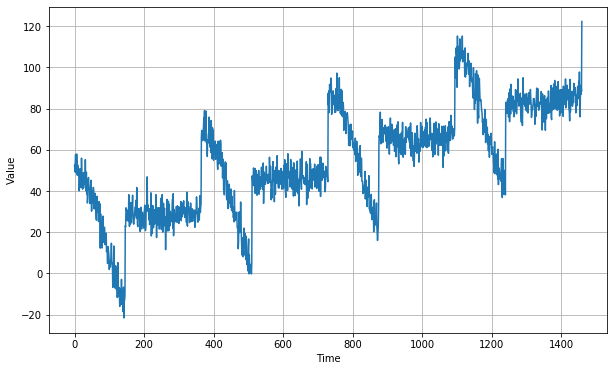

In [0]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## Forecasting with Machine Learning

First, we will train a model to forecast the next step given the previous 20 steps, therefore, we need to create a dataset of 20-step windows for training.

In [0]:
# set up time window

def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [0]:
# define train and validation period

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

### Linear Model

In [0]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# set up train and valid sets as time windows
window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

# define model layers - 1 layer (linear)
model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

# define optimizer
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9) # SGD = stochastic gradient descent optimizer

# fit model
model.compile(loss=keras.losses.Huber(),    # Huber loss is a good loss to use when you are interested in using the "mae"
              optimizer=optimizer,
              metrics=["mae"])
model.fit(train_set, epochs=100, validation_data=valid_set)

Epoch 1/100
31/31 [==============================] - 1s 32ms/step - loss: 46.6127 - mae: 47.9542 - val_loss: 22.8934 - val_mae: 23.3670
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 11.5051 - mae: 11.9459 - val_loss: 9.2357 - val_mae: 9.6871
Epoch 3/100
31/31 [==============================] - 0s 9ms/step - loss: 9.8460 - mae: 10.3805 - val_loss: 9.1530 - val_mae: 9.6008
Epoch 4/100
31/31 [==============================] - 0s 9ms/step - loss: 9.7397 - mae: 10.2880 - val_loss: 9.2402 - val_mae: 9.5627
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 9.6098 - mae: 10.1772 - val_loss: 8.8791 - val_mae: 9.4029
Epoch 6/100
31/31 [==============================] - 0s 9ms/step - loss: 9.5544 - mae: 10.0866 - val_loss: 8.9816 - val_mae: 9.3764
Epoch 7/100
31/31 [==============================] - 0s 9ms/step - loss: 9.5411 - mae: 9.9598 - val_loss: 9.1477 - val_mae: 9.6448
Epoch 8/100
31/31 [==============================] - 0s 9ms/step - loss:

In [0]:
# the above gives around 5.8 mae for the validation set after 100 epochs
# lets try something to figure out the optimal learning rate

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30)) # here Im telling the model to start the learning rate at low of 10 to the -6 power, and increase it by 10x every 30 epochs
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 15ms/step - loss: 67.5573 - mae: 68.2355
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 52.3274 - mae: 52.8279
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 34.6397 - mae: 35.3488
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 17.6722 - mae: 18.2666
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 8.4772 - mae: 9.0412
Epoch 6/100
31/31 [==============================] - 0s 6ms/step - loss: 7.9360 - mae: 8.4686
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 8.0485 - mae: 8.3976
Epoch 8/100
31/31 [==============================] - 0s 6ms/step - loss: 7.8122 - mae: 8.3568
Epoch 9/100
31/31 [==============================] - 0s 6ms/step - loss: 7.8515 - mae: 8.3132
Epoch 10/100
31/31 [==============================] - 0s 6ms/step - loss: 7.8280 - mae: 8.2520
Epoch 11/100
31/31 [==============================

[1e-06, 0.001, 0, 40]

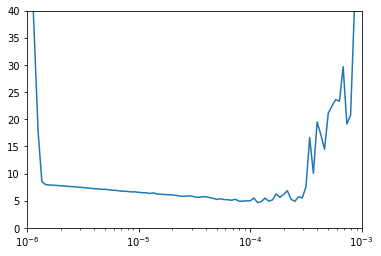

In [0]:
# lets plot the error over the learning rate from the above training session
# here we can see that the learning rate exploded after a while
# we can see the the optimal learning rate is between 10^-5 to 10^-4
# overall 10^-5 is the best one to use

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 40])

In [0]:
# another thing we can use to help is "Early Stopping" callback

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)  # use the 10^-5 learning rate
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10) # add the early stopping callback, if the metric does not improve in the previous 10 epochs, the models stops
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 25ms/step - loss: 46.6127 - mae: 47.9542 - val_loss: 22.8934 - val_mae: 23.3670
Epoch 2/500
31/31 [==============================] - 0s 9ms/step - loss: 11.5051 - mae: 11.9459 - val_loss: 9.2357 - val_mae: 9.6871
Epoch 3/500
31/31 [==============================] - 0s 9ms/step - loss: 9.8460 - mae: 10.3805 - val_loss: 9.1530 - val_mae: 9.6008
Epoch 4/500
31/31 [==============================] - 0s 8ms/step - loss: 9.7397 - mae: 10.2880 - val_loss: 9.2402 - val_mae: 9.5627
Epoch 5/500
31/31 [==============================] - 0s 9ms/step - loss: 9.6098 - mae: 10.1772 - val_loss: 8.8791 - val_mae: 9.4029
Epoch 6/500
31/31 [==============================] - 0s 9ms/step - loss: 9.5544 - mae: 10.0866 - val_loss: 8.9816 - val_mae: 9.3764
Epoch 7/500
31/31 [==============================] - 0s 9ms/step - loss: 9.5411 - mae: 9.9598 - val_loss: 9.1477 - val_mae: 9.6448
Epoch 8/500
31/31 [==============================] - 0s 9ms/step - loss:

In [0]:
# here we see that we got the val mae down to 5.46

In [0]:
# create a function to do model predict
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]
# series[split_time - window_size:-1] means that we start at the split time, and minus the window size so we get that portion for prediction

In [0]:
lin_forecast.shape

(461,)

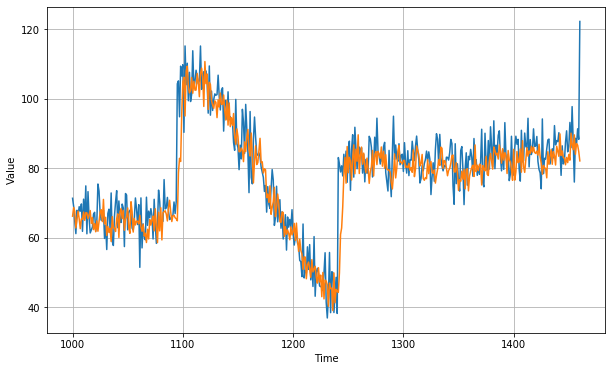

In [0]:
# plot the predictions against validation data

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [0]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

5.343385

In [0]:
# better performance

### Dense Model Forecasting

In [0]:
# lets now add some more Dense layers
# also to test out the learning rate

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(      # we also added this for testing out the learning rate
    lambda epoch: 1e-7 * 10**(epoch / 20)) 
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 17ms/step - loss: 43.7565 - mae: 44.3312
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 41.8288 - mae: 42.0073
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 38.7457 - mae: 39.1402
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 35.3772 - mae: 35.8227
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 31.4448 - mae: 32.0831
Epoch 6/100
31/31 [==============================] - 0s 6ms/step - loss: 27.2989 - mae: 27.9021
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 22.6964 - mae: 23.2716
Epoch 8/100
31/31 [==============================] - 0s 6ms/step - loss: 17.6484 - mae: 18.2723
Epoch 9/100
31/31 [==============================] - 0s 6ms/step - loss: 12.6114 - mae: 13.1545
Epoch 10/100
31/31 [==============================] - 0s 6ms/step - loss: 8.6302 - mae: 9.0650
Epoch 11/100
31/31 [====================

[1e-07, 0.005, 0, 50]

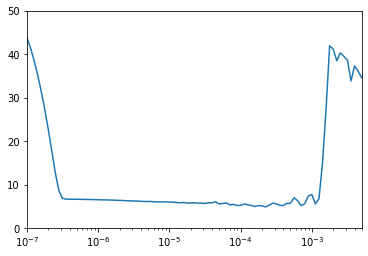

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 50])

In [0]:
# looks like 10^-5 is still the best learning rate
# lets run this again with lr at 10^-5 and early stopping callback

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10) # lets add early stopping
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 24ms/step - loss: 20.0335 - mae: 20.8270 - val_loss: 12.7604 - val_mae: 13.4040
Epoch 2/500
31/31 [==============================] - 0s 10ms/step - loss: 8.6268 - mae: 9.0442 - val_loss: 7.8260 - val_mae: 8.3112
Epoch 3/500
31/31 [==============================] - 0s 10ms/step - loss: 7.9271 - mae: 8.4718 - val_loss: 7.6869 - val_mae: 8.1423
Epoch 4/500
31/31 [==============================] - 0s 10ms/step - loss: 7.6027 - mae: 8.1519 - val_loss: 7.1338 - val_mae: 7.4683
Epoch 5/500
31/31 [==============================] - 0s 9ms/step - loss: 7.3532 - mae: 7.8994 - val_loss: 6.8095 - val_mae: 7.3306
Epoch 6/500
31/31 [==============================] - 0s 9ms/step - loss: 7.1958 - mae: 7.6983 - val_loss: 6.6906 - val_mae: 7.0048
Epoch 7/500
31/31 [==============================] - 0s 9ms/step - loss: 7.0248 - mae: 7.5004 - val_loss: 6.5143 - val_mae: 7.0573
Epoch 8/500
31/31 [==============================] - 0s 9ms/step - loss: 6.

In [0]:
# do the forecast

dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

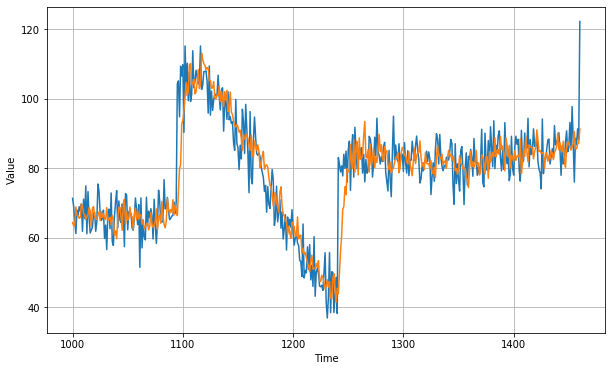

In [0]:
# plot predictions against validation set

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

In [0]:
keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()

5.2994742

In [0]:
# the mae improved